<a href="https://colab.research.google.com/github/moe-yamazaki/ai-picture/blob/main/ai_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 画像分類実践

(colab) ページ上部の ランタイム → ランタイムのタイプを変更 → ハードウェアアクセラレータを「GPU」に変更 → 保存  
深層学習では、簡単な計算を大量に行い学習を進めます。こういった計算にはGPUが適しています。

[参考資料](https://aiacademy.jp/texts/show/?id=164)


### パッケージの準備

In [2]:
# 必要なパッケージをインストール
# !から始まる行はshell command (Pythonではない)
!pip install icrawler

%matplotlib inline
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# ダウンロードした画像を全て同じ大きさにリサイズし、メモリに格納
import numpy as np
import cv2
from pathlib import Path  # ディスク上のファイル一覧を取得するなど、パスの操作に用いるモジュール

name_20 = "20"
name_100 = "100"
name_200 = "200"
name_1000 = "1000"

img_size = 64
imgs_20 = list()
imgs_100 = list()
imgs_200 = list()
imgs_1000 = list()

for img_list, img_dir in ((imgs_20, name_20), (imgs_100, name_100), (imgs_200, name_200), (imgs_1000, name_1000)):
  # 画像パス一つずつを処理
  for impath in Path(img_dir).iterdir():
    # 画像読み込み: cv2.imread()
    img = cv2.imread(str(impath))
    if img is None: continue
    # 画像リサイズ
    img = cv2.resize(img, (img_size, img_size))
    img_list.append(img)

# listをndarrayに変換
imgs_20 = np.array(imgs_20)
imgs_100 = np.array(imgs_100)
imgs_200 = np.array(imgs_200)
imgs_1000 = np.array(imgs_1000)

# テンソルの情報を確認
#print('imgs_20.ndim =', imgs_cat.ndim)
#print('imgs_20.shape =', imgs_cat.shape)
#print('imgs_20.dtype =', imgs_cat.dtype)
#print('')
#print('imgs_dog.ndim =', imgs_dog.ndim)
#print('imgs_dog.shape =', imgs_dog.shape)
#print('imgs_dog.dtype =', imgs_dog.dtype)

In [4]:
# 画像の一覧可視化関数
import math
import PIL

def tile_show(imgs, n_col=10):
  h, w = imgs[0].shape[:2]
  assert all([img.shape[:2] == (h, w) for img in imgs])
  n_row = math.ceil(len(imgs) / n_col)
  tile = np.zeros((h*n_row, w*n_col, 3), imgs[0].dtype)
  for i, img in enumerate(imgs):
    row = i // n_col
    col = i % n_col
    y1 = row * h
    y2 = (row+1) * h
    x1 = col * w
    x2 = (col+1) * w
    tile[y1:y2, x1:x2] = img
  
  if not tile.dtype == np.uint8:
    tile -= tile.min()
    tile /= tile.max()
    tile *= 255
    tile = np.clip(tile.astype(np.uint8), 0, 255)
  return PIL.Image.fromarray(tile[..., ::-1])

15


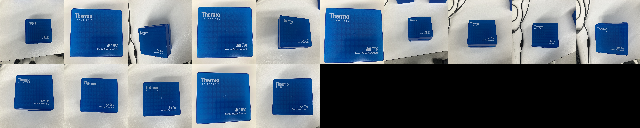

In [5]:
print(len(imgs_20))
tile_show(imgs_20)

9


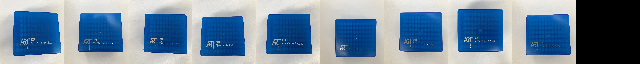

In [6]:
print(len(imgs_100))
tile_show(imgs_100)

16


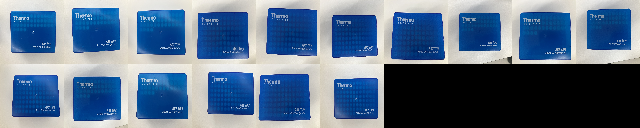

In [7]:
print(len(imgs_200))
tile_show(imgs_200)

15


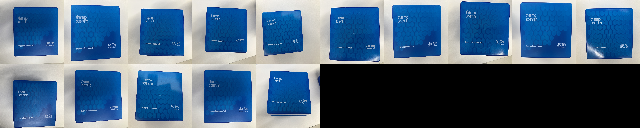

In [8]:
print(len(imgs_1000))
tile_show(imgs_1000)

(45,)


IndexError: ignored

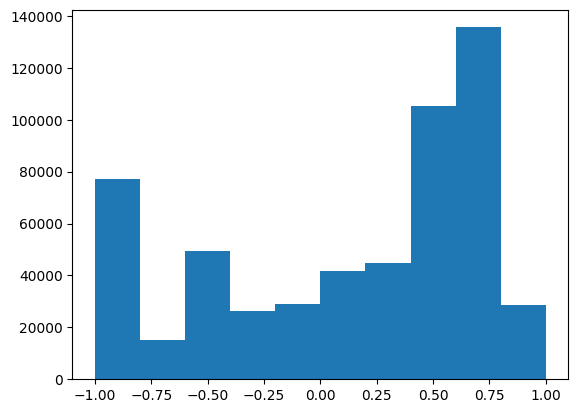

In [18]:
import tensorflow as tf

# 学習データとテストデータの作成
test_rate = 0.2
n_20_test = int(len(imgs_20) * test_rate)
n_100_test = int(len(imgs_100) * test_rate)
n_200_test = int(len(imgs_200) * test_rate)
n_1000_test = int(len(imgs_1000) * test_rate)

test_20, train_20 = imgs_20[:n_20_test], imgs_20[n_20_test:]
test_100, train_100 = imgs_100[:n_100_test], imgs_100[n_100_test:]
test_200, train_200 = imgs_100[:n_200_test], imgs_200[n_200_test:]
test_1000, train_1000 = imgs_100[:n_1000_test], imgs_1000[n_1000_test:]

# ndarrayの結合, dtypeをfloat32に変更, [-1,1]に正規化
train_X = np.concatenate([train_20, train_100, train_200, train_1000], axis=0)
train_X = train_X.astype(np.float32)
train_X = ((train_X / 255.) - 0.5) * 2
test_X = np.concatenate([test_20, test_100, test_200, test_1000], axis=0)
test_X = test_X.astype(np.float32)
test_X = ((test_X / 255.) - 0.5) * 2

# 正規化の確認。train_Xに含まれる全画素の輝度のヒストグラム
plt.hist(train_X.flatten())

# ラベルを作成。猫=0、犬=1として設定
train_y = np.array([0.] * len(train_20) + [1.] * len(train_100) + [2.] * len(train_200) + [3.] * len(train_1000)).astype(np.float32)
test_y = np.array([0.] * len(test_20) + [1.] * len(test_100) + [2.] * len(test_200) + [3.] * len(test_1000)).astype(np.float32)
print(train_y.shape)

# one-hot encoding
train_y = tf.keras.utils.to_categorical(train_y, 2)
test_y = tf.keras.utils.to_categorical(test_y, 2)
print(train_y.shape)

In [20]:
from tensorflow.keras.applications import VGG16

model = VGG16(
    include_top=True, 
    weights=None, 
    input_shape=(img_size, img_size, 3), 
    classes=2,
    )
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

  `tf.keras.Model.summary()`メソッドでは、モデルの各レイヤーのテンソルの形が表示されます (`None`は数値が任意であることを示す) 。モデルを1つの大きな関数として考えた時、重要なのは入力と出力です。  
- input:  `input_5 (InputLayer)        [(None, 64, 64, 3)]`  
- output:   `predictions (Dense)         (None, 2)`

このモデルは、「4次元テンソルを入力されると2次元テンソルを出力する関数」と言えます。


In [21]:
print(train_X.shape)
print(train_y.shape)

(263, 64, 64, 3)
(263, 2)


学習データ画像`train_X`とinputのshape、正解ラベル`train_y`のとoutputのshapeが一致していることが確認できます。

#### ニューラルネットワーク

<img src="https://www.esector.co.jp/bpa/img/A19-034.png" width="500">
<a href="https://www.esector.co.jp/bpa/A19-034.html">src</a>

ニューロンに対応する部分をノードなどと呼ぶ。たいてい1ノードだけで扱うことはなく、層のような構造に例えられるためレイヤーとも呼ばれる

<img src="https://www.imagazine.co.jp/wp-content/uploads/2018/07/086-090_16ISno13_kiso_deep_zu003.jpg" width="500">
<a href="https://www.imagazine.co.jp/%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E3%81%AE%E3%80%8C%E5%9F%BA%E7%A4%8E%E3%81%AE%E5%9F%BA%E7%A4%8E%E3%80%8D%E3%82%92%E7%90%86%E8%A7%A3%E3%81%99/">src</a>

畳み込みニューラルネットワーク（CNN）は、神経細胞の発火のルールを、画像の部分領域をベースにしたという点で、人間の視覚処理により近い構造を模していると考えることができる。

#### 畳み込み処理

<img src="https://axa.biopapyrus.jp/media/CNN_Conv3.png" width="500"><a href="https://axa.biopapyrus.jp/deep-learning/cnn/convolution.html">src</a>

中央の3x3の配列をfilter, kernel, windowなどと呼ぶ。畳み込みは特定のパターン（模様）を抽出する操作だと考えることもでき、フィルターの内容がパターンを決定する。CNNでは、フィルターの中身を学習によって更新し、学習がうまく進むと画像内の特徴量（猫らしさ、犬らしさの指標になる模様など）が抽出できるようになる。


<img src="https://i.stack.imgur.com/wrxLE.png" width="500"><a href="http://web.pdx.edu/~jduh/courses/Archive/geog481w07/Students/Ludwig_ImageConvolution.pdf">src</a>  
カーネルの違いによる畳み込み効果の例

### モデルの学習

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_X, train_y, epochs=30, batch_size=32)

Epoch 1/30
9/9 [==============================] - 19s 157ms/step - loss: 0.6929 - accuracy: 0.5323
Epoch 2/30
9/9 [==============================] - 0s 49ms/step - loss: 0.6921 - accuracy: 0.5323
Epoch 3/30
9/9 [==============================] - 0s 49ms/step - loss: 0.6906 - accuracy: 0.5323
Epoch 4/30
9/9 [==============================] - 0s 49ms/step - loss: 0.6885 - accuracy: 0.5323
Epoch 5/30
9/9 [==============================] - 0s 49ms/step - loss: 0.6879 - accuracy: 0.5323
Epoch 6/30
9/9 [==============================] - 0s 49ms/step - loss: 0.6860 - accuracy: 0.5323
Epoch 7/30
9/9 [==============================] - 0s 49ms/step - loss: 0.6843 - accuracy: 0.5323
Epoch 8/30
9/9 [==============================] - 0s 49ms/step - loss: 0.6819 - accuracy: 0.5323
Epoch 9/30
9/9 [==============================] - 0s 49ms/step - loss: 0.6817 - accuracy: 0.5323
Epoch 10/30
9/9 [==============================] - 0s 50ms/step - loss: 0.6744 - accuracy: 0.5323
Epoch 11/30
9/9 [==========

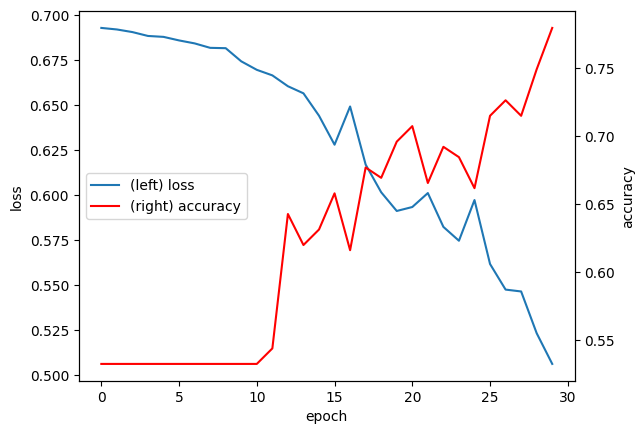

In [23]:
# 学習過程の可視化
fig, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='(left) loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax2 = ax1.twinx()
ax2.plot(history.history['accuracy'], label='(right) accuracy', c='r')
ax2.set_ylabel('accuracy')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='center left')
plt.show()

### 学習したモデルのテスト

テストデータから1枚、画像を取り出して学習したモデルに適用してみる。  
outputは`tf.Tensor`という型であり、`tf.Tensor.numpy()`メソッドによりnumpyの数値として情報を取り出すことができる。

In [24]:
# [-1,1]に正規化されている画像を表示する関数
def show_standardized_img(img):
  img -= img.min()
  img /= img.max()
  img *= 255
  img = np.clip(img, 0, 255).astype(np.uint8)
  return PIL.Image.fromarray(img[..., ::-1])

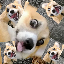

In [25]:
import random
ix = random.randint(0, len(test_X)-1)
show_standardized_img(test_X[ix])

In [26]:
output = model(test_X[ix][np.newaxis], training=False)
print(output)
print(output.numpy())

tf.Tensor([[0. 1.]], shape=(1, 2), dtype=float32)
[[0. 1.]]


`output`の`shape`は (1, 2) となっているが、これは実質的には長さ2のベクトルであり、「猫である確率」と「犬である確率」の順で格納されている。

In [27]:
vector = output.numpy()[0]
print('猫である確率:', f'{vector[0]:.3f}')
print('犬である確率:', f'{vector[1]:.3f}')

猫である確率: 0.000
犬である確率: 1.000


テスト画像の表示とモデルの出力を関数でひとまとめにし、何度か実行してモデルの性能の感覚をつかむ。

In [28]:
def sample_and_predict(model, X):
  ix = random.randint(0, len(X)-1)
  output = model(X[ix][np.newaxis], training=False)
  vector = output.numpy()[0]
  print('猫である確率:', f'{vector[0]:.3f}')
  print('犬である確率:', f'{vector[1]:.3f}')
  return show_standardized_img(X[ix])

猫である確率: 0.568
犬である確率: 0.432


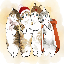

In [29]:
sample_and_predict(model, test_X)

### 精度評価

混合行列 (confusion matrix) を作成する。クラス分類の問題では、正解率や感度など、1つの数字で表現される指標がいくつか存在するが、指標それぞれが見える部分と見えない部分を持つ。

confusion matrixは全ての指標の元になる行列であるので、これさえ載せておけば漏れなく全体を把握することができる。  

今回は「猫と判定すること」を陽性 (positive) として考える。

<img src="https://www.naukri.com/learning/articles/wp-content/uploads/sites/11/2022/03/Confusion-matrix-1.png" width="500"><a href="https://www.naukri.com/learning/articles/web-stories/confusion-matrix-in-machine-learning/">src</a>

In [30]:
# confusion matrixの算出
true = np.argmax(test_y, axis=1)
test_y_hat = model.predict(test_X)
pred = np.argmax(test_y_hat, axis=1)

confmat = tf.math.confusion_matrix(true, pred).numpy()
confmat

2/2 [==============================] - 0s 12ms/step


array([[24, 10],
       [ 9, 21]], dtype=int32)

confusion matrixは包括的な情報ではあるものの、ぱっと見ではよくわからないので指標も計算する。  
ポイント：別名があったり日本語訳がしっくりこなかったりわかりにくい。覚えるというよりは意味合いを把握することが大事

<img src="https://cdn-ssl-devio-img.classmethod.jp/wp-content/uploads/2015/08/Untitled.png"><a href="https://dev.classmethod.jp/articles/aml-evaluation-measures/">src</a>

- 正解率 Accuracy  
$ \frac{TP + TN}{TP + FP + FN + TN} $

- 感度 Sensitivity (Recall, True Positive Rate 再現率 検出率 真陽性率)  
$ \frac{TP}{TP + FN} $  
疾病検査を例にすると、その検査が疾病をとらえる「感度・検出率」となる。(検査で病気と分かった人 / 実際に病気の人)  


- 特異度 Specificity (True Negative Rate 真陰性率)  
$ \frac{TN}{FP + TN} $  
検査で言えば、検査で陰性だった人 / 実際に陰性の人

- 陽性的中率 Positive Predictive Value (Precision 適合度 精度)  
$ \frac{TP}{TP + FP} $  
「陽性適中率が高い」とは、「検査結果が陽性と判定された場合に、真の陽性（有病者）である確率が高い」という意味。


他にも山ほどあります [wikipedia](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers)

In [31]:
[[TP, FP], 
 [FN, TN]] = confmat

accuracy = (TP + TN) / (TP + FP + FN + TN)
sensitivity = TP / (TP + FN)
specificity = TN / (FP + TN)
precision = TP / (TP + FP)

print('正解率', accuracy)
print('感度', sensitivity)
print('特異度', specificity)
print('陽性的中率', precision)

正解率 0.703125
感度 0.7272727272727273
特異度 0.6774193548387096
陽性的中率 0.7058823529411765


### 学習モデルの実利用

学習モデルはデータセット外の実データに適用して初めて役立ちます。  
ここでは例として、画像URLを受け取ると猫か犬か判定してくれるwebサービスを想定します。

(実際のサービス例：[Google Lens](https://lens.google/intl/ja/#:~:text=%E6%A4%8D%E7%89%A9%E3%82%84%E5%8B%95%E7%89%A9,%E7%A2%BA%E8%AA%8D%E3%81%A7%E3%81%8D%E3%81%BE%E3%81%99%E3%80%82))

In [32]:
# urlから画像を読みこむcv2u.urlread()を使用するためパッケージをインストール
!pip install python-opencv-utils
import cv2u

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
#@title 犬猫画像判定サービス { run: "auto", vertical-output: true }

labels = {0: 'ネコ', 1: 'イヌ'}

URL = '' #@param {type:"string"}
try:
  img = cv2u.urlread(URL)
except ValueError:
  img = None

if img is None:
  if URL:
    print('!!! 画像が見つかりません !!!')

else:
  X = cv2.resize(img, (img_size, img_size))
  X = ((X.astype(np.float32) / 255.) - 0.5) * 2
  X = X[np.newaxis]
  y = model.predict(X)
  label = labels[np.argmax(y[0])]
  score = np.max(y) * 100
  print(f'これは {score: .1f}% 「{label}」 です！')
  plt.imshow(img[..., ::-1])
  plt.axis("off")
  plt.show()

### より良い精度を目指して

- データセットの量を増やす  
今回のデモでは各クラスの画像の最大量は200枚としました。一般的には学習量を増やせば精度が向上する傾向にあります。

- 質の高いデータセットの準備  
画像データを可視化するとわかりますが、スクレイピングで得られた画像には全く関係ないものがある程度含まれます。これらを取り除き、質の高いデータセットを構築することが精度向上につながります。

- データの水増し (データ拡張、Data Augmentation)  
データセットの量を増やすのは人力が多く骨が折れます。水増しの手法では、1枚の画像を疑似的に増幅し、枚数が増えたように見せかけます。  
<img src="https://qph.fs.quoracdn.net/main-qimg-7565e09ecc4a93604b9c26c8c2a89bf9-pjlq" width="500"><a href="https://www.quora.com/What-is-data-augmentation-in-CNN">src</a>

- モデルの変更  
VGG16は2014年に開発されたモデルで古いため、よりよいモデルが多く開発されています。   
代表的なもの: ResNet (2015), EfficientNet (2019)